# Teaching the network to emulate a dynamical system via learning and input signals

Consider a linear basic network modified via a Rand-Sig kernel. We can write the dual form of the dynamics as

$$\tau \frac{d\mathbf{x}}{dt} \approx 
 -\mathbf{x} + C \sum_{\mathbf{x}^*} \boldsymbol{\alpha}(\mathbf{x}^*)
(1 - \theta(\mathbf{x}, \mathbf{x}^*)/\pi) + B\mathbf{u}(t)$$

where $\mathbf{x}^*$ are the support states.

If a flow-field can be expressed in terms of support states, we can construct sequence of input signals $\mathbf{u}(t)$ and learning signals $\{l_d(t)\}$ that will produce this flow field. This is because the effect of a support state $\mathbf{x}^*$ on a state $\mathbf{x}$ depends only on the angle between the two states. Therefore, to add a support state to the network, we can give a large input in the direction of the support state that forces the network into that support state, followed by a learning signal that binds that support state to a particular control direction $C\boldsymbol{\alpha}(\mathbf{x}^*)$.

Here we will use the following algorithm. Let $B = C = I$ for simplicity. To add support state $\mathbf{x}_i^*$ attached to control direction $\boldsymbol{\alpha}(\mathbf{x}_i^*)$, drive the system with input $\mathbf{u}(t) = \lambda \mathbf{x}_i^*$ for $T=5\tau$, and on the final timestep of the drive apply learning signal $\mathbf{l}(t) = \boldsymbol{\alpha}(\mathbf{x}_i^*)\delta(t-T)$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from aux import get_flow, run_fwd_np
from disp import set_plot, colors, quiver
from kernels import make_psi_rand_sgm

D = 2  # system dim

### Online learning simulation

In [2]:
# simulation params
t = np.arange(0, .25, .001)
DT = np.mean(np.diff(t))

IT_CUE_1 = int(round(.05//DT))
IT_CUE_2 = int(round(.15//DT))

LAM_CUE = .02/DT

# base system params
TAU = .01
B = np.eye(D)
C = np.eye(D)

N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)
psi, ker = make_psi_rand_sgm(J_PSI)

# cues
us_cue = np.zeros((len(t), D))
us_cue[IT_CUE_1, 1] = LAM_CUE
us_cue[IT_CUE_2, 1] = -LAM_CUE

# for plotting flow fields
RX = np.linspace(-1.5, 1.5, 12)
DX = np.mean(np.diff(RX))

### Two fixed points via two support states

In [3]:
LAM = 2

# learning input and signals
us_learn = np.zeros((len(t), D))
ls_learn = np.zeros((len(t), D))

us_learn[(0.05 <= t)&(t < 0.1), 1] = LAM  # support state in direction of (0, 1)
ls_learn[int(round(.1/DT))-1, 1] = 1/DT  # control signal in direction of (0, 1)

us_learn[(0.15 <= t)&(t < .2), 1] = -LAM  # support state in direction of (0, -1)
ls_learn[int(round(.2/DT))-1, 1] = -1/DT  # control signal in direction of (0, -1)

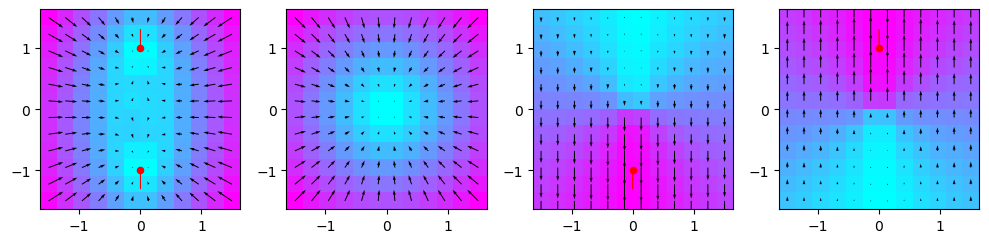

In [4]:
# target flow field
x_stars = np.array([ [0., -1], [0, 1]])
alphas =  np.array([ [0., -1], [0, 1]])

# final flow field
df = lambda x: C@np.sum([alpha*ker(x_star, x) for alpha, x_star in zip(alphas, x_stars)], axis=0)
F = lambda x, u: (1/TAU)*(-x + df(x))

flow = get_flow(F, RX)

# base flow field
df_0 = lambda x: 0
F_0 = lambda x, u: (1/TAU)*(-x + df_0(x))

flow_0 = get_flow(F_0, RX)

# contribution from first support state
df_1 = lambda x: C@alphas[0]*ker(x_stars[0], x)
F_1 = lambda x, u: (1/TAU)*(df_1(x))

flow_1 = get_flow(F_1, RX)

# contribution from second support state
df_2 = lambda x: C@alphas[1]*ker(x_stars[1], x)
F_2 = lambda x, u: (1/TAU)*(df_2(x))

flow_2 = get_flow(F_2, RX)

arrow_scale=.3
fig, axs = plt.subplots(1, 4, figsize=(10, 2.5), tight_layout=True)

axs[0].matshow(np.linalg.norm(flow, axis=2).T, origin='lower', cmap='cool', extent=2*[RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[0], flow, RX)
axs[0].set_aspect('equal')

for x_star, alpha in zip(x_stars, alphas):
    axs[0].scatter(*x_star, c='r', s=20)
    axs[0].arrow(*x_star, *alpha*arrow_scale, lw=.5, color='r')

axs[1].matshow(np.linalg.norm(flow_0, axis=2).T, origin='lower', cmap='cool', extent=2*[RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[1], flow_0, RX)
axs[1].set_aspect('equal')

axs[2].matshow(np.linalg.norm(flow_1, axis=2).T, origin='lower', cmap='cool', extent=2*[RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[2], flow_1, RX)
axs[2].set_aspect('equal')

axs[2].scatter(*x_stars[0], c='r', s=20)
axs[2].arrow(*x_stars[0], *alphas[0]*arrow_scale, lw=.5, color='r')

axs[3].matshow(np.linalg.norm(flow_2, axis=2).T, origin='lower', cmap='cool', extent=2*[RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[3], flow_2, RX)
axs[3].set_aspect('equal')

axs[3].scatter(*x_stars[1], c='r', s=20)
axs[3].arrow(*x_stars[1], *alphas[1]*arrow_scale, lw=.5, color='r')

for ax in axs:
    ax.xaxis.tick_bottom()
    
fig.savefig('ms/3_targ_flow_fps.svg')

In [5]:
save = {'pre': {}, 'learn': {}, 'post': {}}

W = np.zeros((N, D))

# pre-learning
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = np.zeros(D)

ls = np.zeros((len(t), D))

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_cue[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
save['pre']['xs'] = xs.copy()
save['pre']['us'] = us_cue.copy()
save['pre']['ls'] = ls.copy()

# learning
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = save['pre']['xs'][-1, :]

ls = ls_learn.copy()

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_learn[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
    # implement plasticity rule
    if np.linalg.norm(ls[ct]) > 0:
        for d in range(D):
            W[:, d] += (DT*ls[ct, d]*psi(xs[ct, :]))
    
save['learn']['xs'] = xs.copy()
save['learn']['us'] = us_learn.copy()
save['learn']['ls'] = ls.copy()

# post-learning
xs = np.nan*np.zeros((len(t), D))
xs[0, :] = save['learn']['xs'][-1, :]

ls = np.zeros((len(t), D))

for ct, t_ in enumerate(t[1:], 1):
    dx = (DT/TAU)*(-xs[ct-1, :] + C@(W.T)@psi(xs[ct-1, :]) + B@us_cue[ct, :])
    xs[ct, :] = xs[ct-1, :] + dx
    
save['post']['xs'] = xs.copy()
save['post']['us'] = us_cue.copy()
save['post']['ls'] = ls.copy()

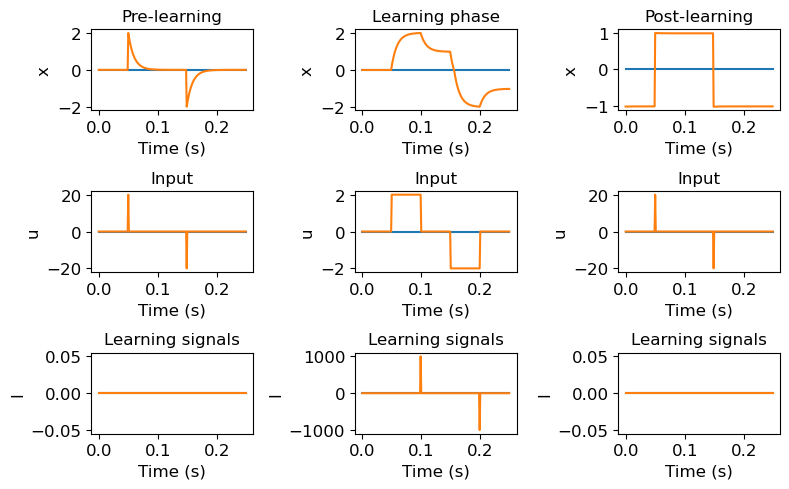

In [7]:
fig, axs = plt.subplots(3, 3, figsize=(8, 5), tight_layout=True)

axs[0, 0].plot(t, save['pre']['xs'])
set_plot(axs[0, 0], x_label='Time (s)', y_label='x', title='Pre-learning')
axs[1, 0].plot(t, save['pre']['us'])
set_plot(axs[1, 0], x_label='Time (s)', y_label='u', title='Input')
axs[2, 0].plot(t, save['pre']['ls'])
set_plot(axs[2, 0], x_label='Time (s)', y_label='l', title='Learning signals')

axs[0, 1].plot(t, save['learn']['xs'])
set_plot(axs[0, 1], x_label='Time (s)', y_label='x', title='Learning phase')
axs[1, 1].plot(t, save['learn']['us'])
set_plot(axs[1, 1], x_label='Time (s)', y_label='u', title='Input')
axs[2, 1].plot(t, save['learn']['ls'])
set_plot(axs[2, 1], x_label='Time (s)', y_label='l', title='Learning signals')

axs[0, 2].plot(t, save['post']['xs'])
set_plot(axs[0, 2], x_label='Time (s)', y_label='x', title='Post-learning')
axs[1, 2].plot(t, save['post']['us'])
set_plot(axs[1, 2], x_label='Time (s)', y_label='u', title='Input')
axs[2, 2].plot(t, save['post']['ls'])
set_plot(axs[2, 2], x_label='Time (s)', y_label='l', title='Learning signals')

fig.savefig('ms/3_feed_forward_learning_fps.svg')